In [45]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy.matlib as matlib
from scipy.stats import multivariate_normal
import numpy as np
import support_code
%matplotlib inline

In [2]:
def logreg_logsumexp(s):
    """Calculates log(exp(0) + exp(-s))"""
    return np.logaddexp(0, -s)

## Regularized Logistic Regression

In [3]:
def map_y(y, method=None):
    if method == "erm":
        y_new = np.zeros(len(y))
        for i in range(len(y)):
            if y[i] == 1:
                y_new[i] = 1
            else: 
                y_new[i] = -1
    elif method == "loglikelihood":
        y_new = np.zeros(len(y))
        for i in range(len(y)):
            if y[i] == 1:
                y_new[i] = 1
            else: 
                y_new[i] = 0
    y_new = np.array(y_new).reshape(y.shape)
    return y_new

In [4]:
def f_objective(theta, X, y, l2_param=1):
    '''
    Args:
        theta: 1D numpy array of size num_features
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        l2_param: regularization parameter

    Returns:
        objective: scalar value of objective function
    '''
    y_new = map_y(np.array(y),"erm")
    
    objective = (1/(len(y_new)))*\
    (logreg_logsumexp(np.dot(np.transpose(y_new),np.dot(X,theta))) \
     + (l2_param*(np.dot(np.transpose(theta), theta))))
    
    return objective

In [5]:
import pandas as pd
X_train = np.array(pd.read_csv('logistic-code/X_train.txt', header=None))
X_val = np.array(pd.read_csv('logistic-code/X_val.txt', header=None))
y_train = np.array(pd.read_csv('logistic-code/y_train.txt', header=None))
y_val = np.array(pd.read_csv('logistic-code/y_val.txt', header=None))

In [6]:
## Check if this is correct

from sklearn.preprocessing import StandardScaler
## X scaling
scaler = StandardScaler()
scaler.fit(X_train)
# print (scaler.mean_)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [7]:
def add_bias(X):
    X_new = np.array([np.hstack((1, i)) for i in X])
    return X_new

In [8]:
X_train = add_bias(X_train)
X_val = add_bias(X_val)

In [9]:
X_train.shape

(1600, 21)

### Preprocessing

In [10]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

In [11]:
def log_likelihood(X, y, theta):
    theta = np.array(theta).reshape(-1)
    y = np.array(y).reshape(-1)
    log_likelihood = ((np.dot(np.transpose(y), [logreg_logsumexp(np.dot(X[i], theta)) for i in range(len(X))]))+\
                      (np.dot(np.transpose(np.array([1-y[i] for i in range(len(y))])), np.array([np.exp(np.dot(X[i], theta))*logreg_logsumexp(np.dot(X[i], theta)) for i in range(len(X))]))))
    return log_likelihood

In [13]:
class LogRegression(BaseEstimator, RegressorMixin):
    """ Regularized Logistic Regression"""

    def __init__(self, l2param=1):
        if l2param < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2param = l2param
        
    def fit(self, X, y):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = map_y(y, "loglikelihood")
        y = y.reshape(-1)
        l2param = self.l2param
        
        def f_objective(theta):
            '''
            Args:
                theta: 1D numpy array of size num_features
                X: 2D numpy array of size (num_instances, num_features)
                y: 1D numpy array of size num_instances
                l2_param: regularization parameter

            Returns:
                objective: scalar value of objective function
            '''
            y_new = map_y(np.array(y),"erm")
            s = np.dot(X, theta)
            h = logreg_logsumexp(np.dot(np.transpose(y), s))
            objective = -(1/(len(y)))*h + (1/(len(y)))*l2param*(np.dot(np.transpose(theta), theta))
            return objective   ### erm objective'ini minimize ediyorsun problem olmamasi lazim
        
        self.f_objective = f_objective
        theta_0 = np.zeros(num_ftrs)
        self.theta_ = minimize(f_objective, theta_0).x 
        ## Final loss'u display etmek istediginde asagidakini kullan, normalde gerek yok 
#         self.theta_ = minimize(f_objective, theta_0, options={'disp': True}).x
        return self

    def predict(self, X):
        try:
            getattr(self, "theta_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.theta_)

    def score(self, X, y):
        # Average log loss
        try:
            getattr(self, "theta_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        ## log-likelihood - not negative
        theta = np.array(self.theta_).reshape(-1)
        y = map_y(np.array(y), method="erm")
        s = np.dot(X, theta)
#         l2param = self.l2param
        h = - logreg_logsumexp(np.dot(np.transpose(y), s))
        log_likelihood = h
        return log_likelihood
    

In [29]:
def simple_sigmoid(x):
    sigmoid = 1/(1+np.exp(-x))
    return sigmoid

In [30]:
class NNL_LogRegression(BaseEstimator, RegressorMixin):
    """ Regularized Logistic Regression"""
    def __init__(self, l2param=1):
        if l2param < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2param = l2param
        
    def fit(self, X, y):
        n, num_ftrs = X.shape
        l2param = self.l2param
        
        def nll_objective(theta):
            '''
            Args:
                theta: 1D numpy array of size num_features
                X: 2D numpy array of size (num_instances, num_features)
                y: Column vector size num_instances
                l2_param: regularization parameter

            Returns:
                objective: Negative LogLikelihood
            '''
            ## map y values to "likelihood" values
            y_new = np.array(map_y(np.array(y),"loglikelihood").ravel())
            s = np.dot(X, theta)
            h = np.log(1) - logreg_logsumexp(s)
            
            ## NLL objective
            objective = np.dot(np.transpose((-1)*y_new),h) + \
            np.dot((y_new-1),(-s+h)) + \
            l2param*(np.dot(np.transpose(theta), theta))
            return objective  
        
        self.nll_objective = nll_objective
        theta_0 = np.zeros(num_ftrs) 
        ## Minimize NLL objective
        self.theta_ = minimize(nll_objective, theta_0).x 
        return self

    def predict(self, X):
        try:
            getattr(self, "theta_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return simple_sigmoid(np.dot(X, self.theta_))

    def score(self, X, y):
        # Log Likelihood - not negative
        try:
            getattr(self, "theta_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        theta = np.array(self.theta_).reshape(-1)
        y_new = np.array(map_y(np.array(y),"loglikelihood").ravel())
        s = np.dot(X, theta)
        l2param = self.l2param
        h = np.log(1) - logreg_logsumexp(s)
        log_likelihood = np.dot(np.transpose(y_new),h) + \
        np.dot((1-y_new),(-s+h))
        return log_likelihood
    

## Zooming In

In [54]:
lambdas_zoom = list(np.linspace(25, 40, 50))
param_thetas = {}
param_scores = {}

for param in lambdas_zoom:
    logistic_regression = NNL_LogRegression(l2param=param)
    param_thetas[param] = logistic_regression.\
    fit(X_train, y_train).theta_
    param_scores[param] = logistic_regression.\
    score(X_val, y_val)

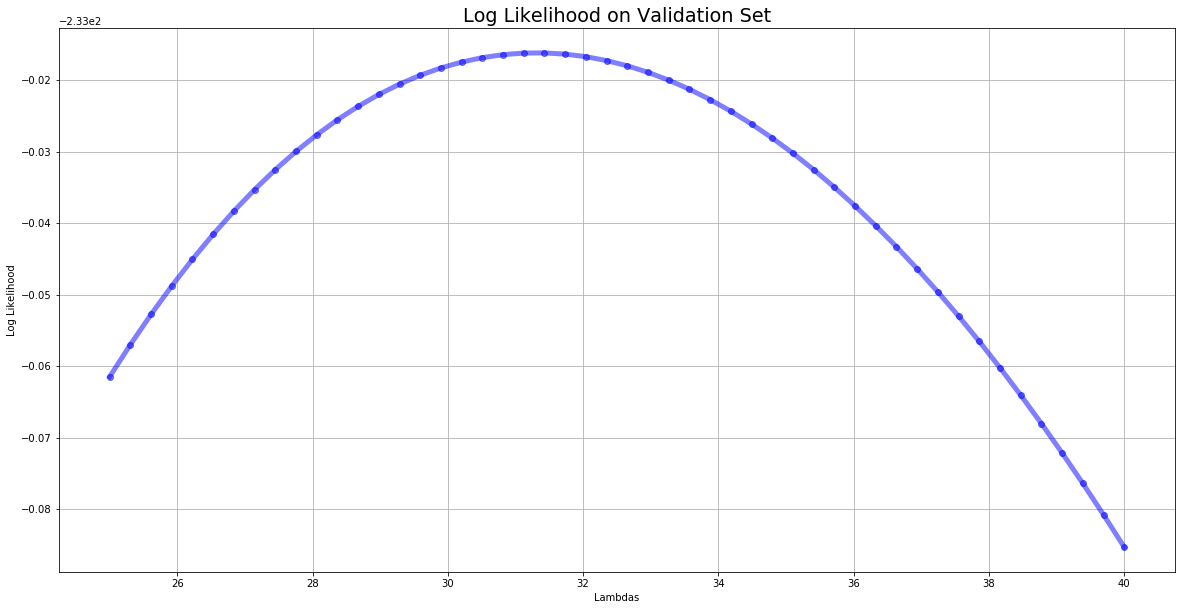

In [55]:
score_list = []
for param in param_scores.keys():
    score_list.append(param_scores[param])
plt.figure(figsize=(20,10))
plt.plot(lambdas_zoom, score_list, marker="o", color="b", \
         alpha=0.5, linewidth=5)
# plt.xticks(lambdas_zoom, rotation=90)
plt.rcParams['font.size']=16
plt.title("Log Likelihood on Validation Set")
plt.xlabel("Lambdas")
plt.ylabel("Log Likelihood")
plt.grid()

## Again

In [56]:
lambdas_zoom = list(np.linspace(30, 32, 50))
param_thetas = {}
param_scores = {}

for param in lambdas_zoom:
    logistic_regression = NNL_LogRegression(l2param=param)
    param_thetas[param] = logistic_regression.\
    fit(X_train, y_train).theta_
    param_scores[param] = logistic_regression.\
    score(X_val, y_val)

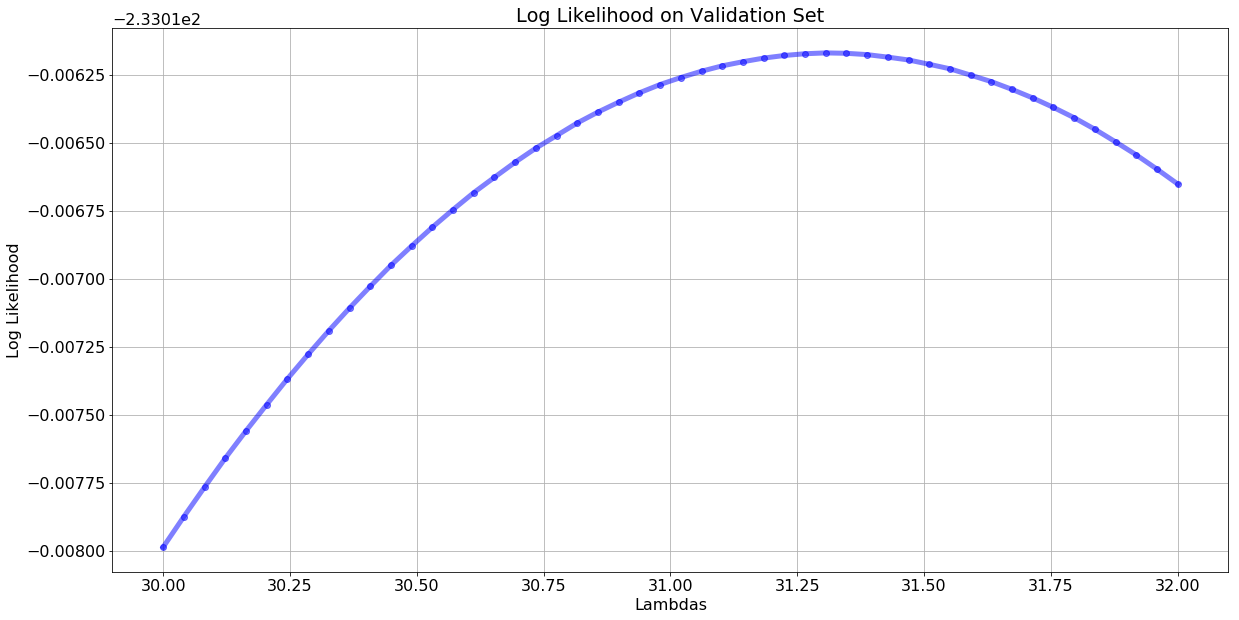

In [57]:
score_list = []
for param in param_scores.keys():
    score_list.append(param_scores[param])
plt.figure(figsize=(20,10))
plt.plot(lambdas_zoom, score_list, marker="o", color="b", \
         alpha=0.5, linewidth=5)
# plt.xticks(lambdas_zoom, rotation=90)
plt.rcParams['font.size']=16
plt.title("Log Likelihood on Validation Set")
plt.xlabel("Lambdas")
plt.ylabel("Log Likelihood")
plt.grid()

In [58]:
lambdas_zoom = np.linspace(31.25, 31.35, 50)
param_thetas = {}
param_scores = {}

for param in lambdas_zoom:
    logistic_regression = NNL_LogRegression(l2param=param)
    param_thetas[param] = logistic_regression.\
    fit(X_train, y_train).theta_
    param_scores[param] = logistic_regression.\
    score(X_val, y_val)

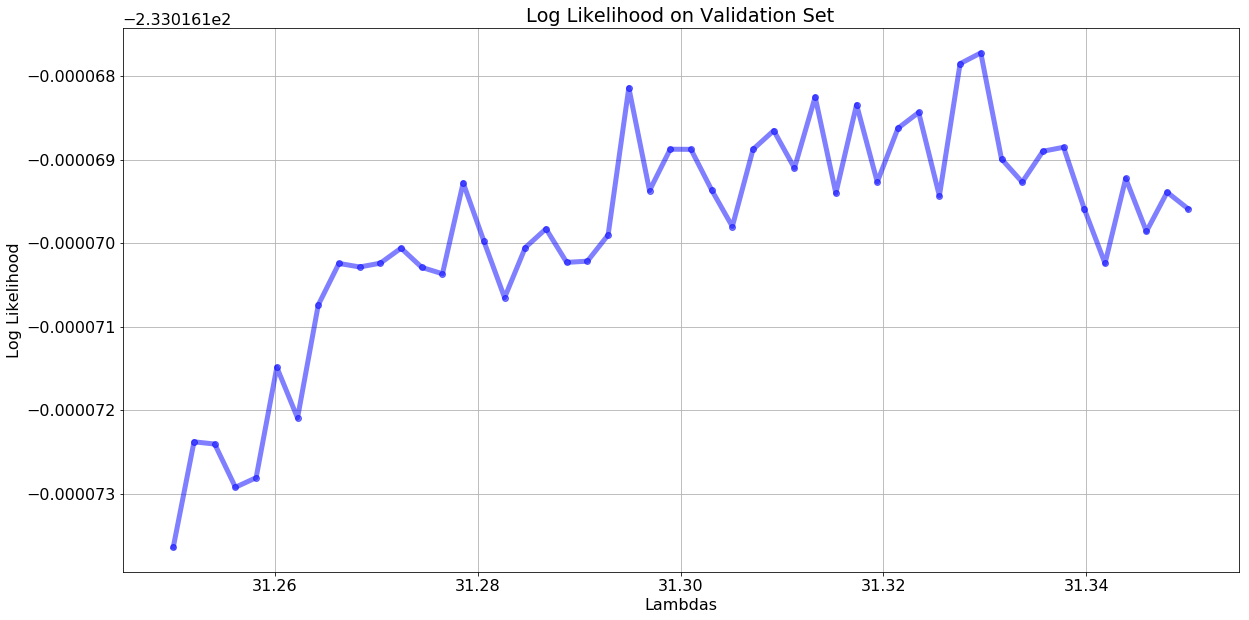

In [59]:
score_list = []
for param in param_scores.keys():
    score_list.append(param_scores[param])
plt.figure(figsize=(20,10))
plt.plot(lambdas_zoom, score_list, marker="o", color="b", \
         alpha=0.5, linewidth=5)
# plt.xticks(lambdas_zoom, rotation=90)
plt.rcParams['font.size']=16
plt.title("Log Likelihood on Validation Set")
plt.xlabel("Lambdas")
plt.ylabel("Log Likelihood")
plt.grid()

## Calibration Plots

In [60]:
x = np.arange(0, 1, 0.05)
intervals = [[x[i], x[i+1]] for i in range(len(x)-1)]

In [61]:
x

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95])

In [62]:
def plot_calibration(NNL_LogRegression, l2reg=4e-6, \
                intervals=intervals, xtrain=X_train, \
                ytrain=y_train, xval=X_val, yval=y_val):
    '''Args:
    - Logistic Regression Class: NLL_LogRegression from the previous question
    - l2reg = l2 regularization parameter lambda
    - intervals: calibration intervals to check
    - xtrain, ytrain: training set to use
    - xval, yval: validation set to use
    
    Returns:
    - Values to generate calibration plots'''
    

    logistic = NNL_LogRegression(l2param=l2reg)
    ytrain = map_y(ytrain, method="loglikelihood")
    logistic.fit(xtrain, ytrain)
    preds = logistic.predict(xval)
    trues = yval.ravel()
    
    interval_indexes = {}
    for i in range(len(np.array(intervals))):
        ## preds in interval 1, interval 2, ...
        interval_indexes[i] = \
        np.where(np.logical_and(preds>intervals[i][0], preds<intervals[i][1]))
    
    ones_ratios = []
    for limit in interval_indexes.keys():
#         print (yval[interval_indexes[limit]])
        ratio = \
    np.sum(trues[interval_indexes[limit]])/len(trues[interval_indexes[limit]])
        ones_ratios.append(ratio)
    
    return ones_ratios

In [63]:
logreg = NNL_LogRegression(l2param=31.3296)

In [64]:
logreg.fit(X_train, y_train)

NNL_LogRegression(l2param=31.3296)

/Users/derin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/Users/derin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


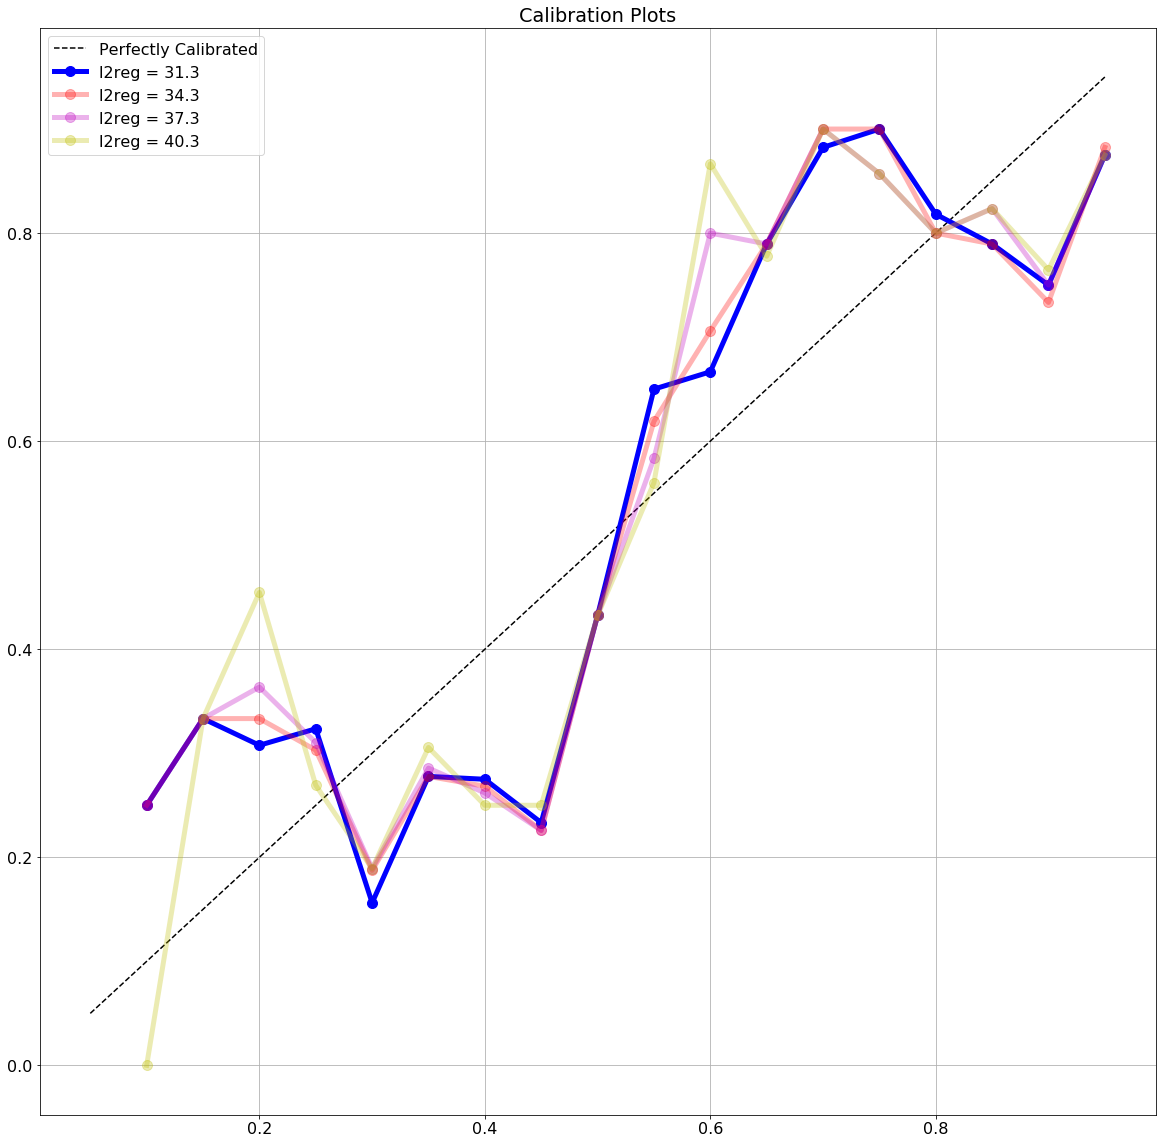

In [65]:
plt.figure(figsize=(20,20))
cs = ["b", "r", "m", "y"]
l2regs = np.linspace(31.3, 40.3, 4)

plt.plot(x[1:], x[1:], "--", color="k", label = "Perfectly Calibrated")
plt.plot(x[1:], plot_calibration(NNL_LogRegression, l2reg=l2regs[0], \
                intervals=intervals, xtrain=X_train, \
                ytrain=y_train, xval=X_val, yval=y_val), color=cs[0], linewidth=5, \
             marker="o", markersize=10, label="l2reg = " + str(l2regs[0]))
for i in range(1, len(l2regs)):
    plt.plot(x[1:], plot_calibration(NNL_LogRegression, l2reg=l2regs[i], \
                intervals=intervals, xtrain=X_train, \
                ytrain=y_train, xval=X_val, yval=y_val), color=cs[i], linewidth=5, \
             marker="o", markersize=10, alpha=0.3, label="l2reg = " + str(l2regs[i]))

plt.xticks = x
plt.grid()
plt.rcParams['font.size'] = 16
plt.title("Calibration Plots")
plt.legend()